KeyboardInterrupt: 

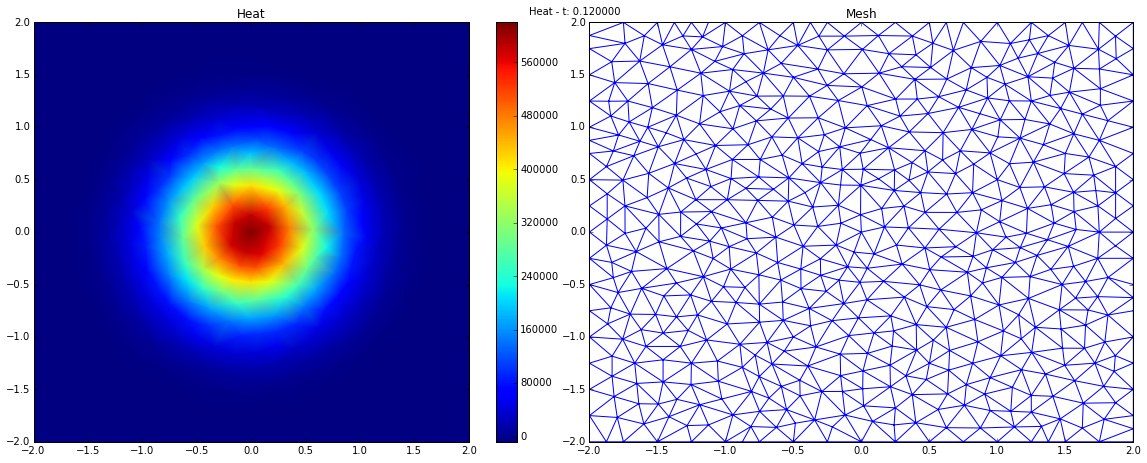

In [5]:
%matplotlib inline
%run /home/fenics/fenics-matplotlib.py
from dolfin import *; 
from mshr import *; 
from IPython.display import display, clear_output; 
import time
import logging; 
logging.getLogger('FFC').setLevel(logging.WARNING)

# Compact plot utility function
def plot_compact(u, t, stepcounter): 
    if stepcounter % 5 == 0:
        uEuclidnorm = project(u, V);
        
        ax.cla(); 
        fig = plt.gcf(); 
        fig.set_size_inches(16, 6.5)
        
        # Plot norm of velocity
        plt.subplot(1, 2, 1); 
        mplot_function(uEuclidnorm); 
        plt.title("Heat")
        
        if t == 0.: 
            plt.colorbar(); 
        
        plt.axis(G)
        plt.subplot(1, 2, 2);
        if t == 0.: 
            # Plot mesh
       	    plt.triplot(mesh2triang(mesh));
            plt.title("Mesh") 
            
        plt.suptitle("Heat - t: %f" % (t)); 
        plt.tight_layout(); 
        clear_output(wait=True); 
        display(pl)   

# Define domain and mesh
XMIN, XMAX = -2., 2.; 
YMIN, YMAX = -2., 2.; 
G = [XMIN, XMAX, YMIN, YMAX];
mresolution = 20;
mesh = generate_mesh(Rectangle(Point(G[0], G[2]), Point(G[1], G[3])), mresolution)

# Define FEM function space
degree = 1;
V = FunctionSpace(mesh, "CG", degree);

# Define test and trial functions
v = TestFunction(V); 
u = Function(V);

# Parameters
theta = 1.0 # 1.0-Implicit Euler, 0.5-Midpoint rule, 0-Explicit Euler
k = 0.001; 
t, T = 0., 20.;

# Initial solution
k_coeff = 1
ue = Expression("exp(-(x[0]*x[0]+x[1]*x[1])/(4*a*t))/(4*pi*a*t)", a=k_coeff, t=1e-7, domain=mesh) 
u0 = ue;

# Define Dirichlet boundary 
def boundary(x, on_boundary):  
    return on_boundary

bc = DirichletBC(V, ue, boundary)

pl, ax = plt.subplots(); 

# Initialize time-stepping
stepcounter = 0; 
timer0 = time.clock()

# Time-stepping loop
while t < T: 
    # Velocity for the chosen time scheme  
    um = theta*u + (1.0-theta)*u0 
    
    # Solve the heat equation (one time step)
    r = (u - u0)/k*v*dx + k_coeff*inner(grad(um), grad(v))*dx
    solve(r==0, u, bc)  
    
    # Plot all quantities
    plot_compact(u, t, stepcounter) 
    
    # Shift to next time step
    t += k; 
    u0 = project(u, V); 
    ue.t = t;
    stepcounter += 1 
    e1 = assemble((ue-u0)*(ue-u0)*dx)
    e2 = assemble(ue*ue*dx)
    re = sqrt(e1/e2);
    print "Relative error: ", re 
    
print "elapsed CPU time: ", (time.clock() - timer0)  